- Total number of drops 1000
- Gamma distribution params 4.0 2.5e-06
- Drop Radius: mean,SD,max  9.86698820231796e-06 1.1519424058759235e-06 4.3330583921399237e-05
- Total potential available rain is  0.7876013623864414  mm


RuntimeError: Requested MovieWriter (ffmpeg) not available

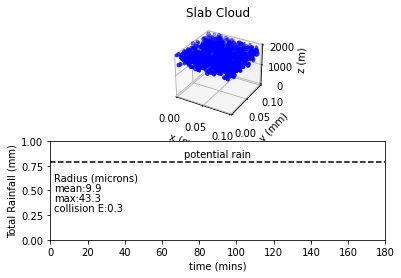

In [2]:
#%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
from IPython.display import HTML, display
from matplotlib import rc


global rain

def terminal_w(r):
    """calculation of droplet terminal fallspeed"""
    w=np.where(r<30.e-6,X1*r**2,X2*r)
    w=np.where(r>1.e-3,X3*np.sqrt(r),w)
    return(w)

def r2mass(r):
    """converts radius to mass"""
    return((4.0*rho_l*np.pi*r**3)/3.0)

def mass2r(m):
    """converts radius to mass"""
    r=((3.0*m)/(4.0*rho_l*np.pi))**(1./3.)
    return(r)

class cloud():
    """class of a cloud with arrays of x,y,z,r and w"""
    def __init__(self,xpos,ypos,zpos,radius):

        # position vectors and radius (could use array)
        #self.x=ma.masked_array(xpos,mask=np.zeros(len(xpos)))
        #self.y=ma.masked_array(ypos,mask=np.zeros(len(ypos)))
        #self.z=ma.masked_array(zpos,mask=np.zeros(len(zpos)))
        #self.r=ma.masked_array(radius,mask=np.zeros(len(radius)))

        self.x=xpos
        self.y=ypos
        self.z=zpos
        self.r=radius
        self.dead=np.zeros(len(radius))
        self.rain=0.0
        
        # vertical velocity
        self.w=terminal_w(radius) # velocity  
        
    def collision(self):
        from scipy.spatial.distance import cdist
        ndrop=len(self.r) # how many drops?

        # need to get pairwise sum of radii to determine collisions sphere
        rsq=np.tile(self.r,(ndrop,1))
        rsum=rsq+np.transpose(rsq) # paired radius sum

        # now find collisions
        # check if pairs in same "x-y" space
        coords=np.column_stack((self.x,self.y))    
        xydist=cdist(coords,coords)
        
        # and if points have "swapped" their z-locations, i.e.
        # one cloud drop has overtaken another?
        zd1=np.subtract.outer(self.z,self.z)
        zd2=np.subtract.outer(self.znew,self.znew)
        
        # if zd1*zd2<0 then drop overtake has occurred
        ind1,ind2=np.where((xydist<rsum)&(zd1*zd2<0.0))
        
        # list of unique pairs neglecting diagonals (impacts itself!)
        unique=(ind1<ind2)
        ind1 = ind1[unique]
        ind2 = ind2[unique]

        # loops over lower triangle of all column-collisions
        for i1,i2 in zip(ind1,ind2):
            if (self.dead[i1]):
                continue
            if (self.dead[i2]):
                continue
            if (np.random.uniform(low=0,high=1)>collision_E): 
                continue
            #print("cloud bump",xydist[i1,i2])
            #print(1,self.x[i1],self.y[i1],self.z[i1],self.znew[i1],self.r[i1])
            #print(2,self.x[i2],self.y[i2],self.z[i2],self.znew[i2],self.r[i2])

            # new mass, radius and terminal velocity 
            mass1=r2mass(self.r[i1])
            mass2=r2mass(self.r[i2])
            
            self.r[i1]=mass2r(mass1+mass2)
            self.w[i1]=terminal_w(self.r[i1])
            self.znew[i1]=min(self.znew[i1],self.znew[i2])

            # other drop is now dead:
            self.dead[i2]=True
            self.r[i2]=self.w[i2]=0.0
            self.znew[i2]=self.z[i2]=-1.e6
            
            #self.x.mask[i2]=self.y.mask[i2]=True
            #self.z.mask[i2]=True
            #self.r.mask[i2]=True

    def raincalc(self):
        """check for self below surface"""
        rain_idx=np.argwhere(self.z<0.0)
        mass_vec=r2mass(self.r[rain_idx])
        rain=np.sum(mass_vec)/xysize
        self.rain+=rain 
        self.dead[rain_idx]=True
        self.r[rain_idx]=0.0 # zero mass.

def main():
    # dimensions of the domain
    global xsize,ysize,zsize,xysize
    global X1,X2,X3
    global dt # timestep
    global rho_l
    global rsmall,rlarge
    global collision_E

    # physical constants:
    #-------------------
    # terminal velocity coeffs
    X1,X2,X3=1.2e8,8e3,250. 
    # density of liquid water
    rho_l=1000.
    slice=1

    #----------------------------------------------    
    # parameters that can be varied for experiment:
    #----------------------------------------------
    # domain size in meters
    xsize=ysize=0.0001
    zsize=2000
    
    # vertical extend of cloud
    zcloud1=1500.
    zcloud2=zsize

    # collision efficiency, simple fixed constant
    # students can replace with fit to data F(R,r)
    collision_E=0.3

    # timestep (seconds) 
    dt=60.0 # seconds
    lentime=180 # total time of animation (minutes)

    #
    # Student exercise 1: change (a) large radii (b) physical cloud z (c)CCN
    #
    #liq=0.5e-3 # cloud liq water content in kg/m**3    
    ccn=200.  # ccn per cm**-3
    rsmall=10.e-6 # microns

    bimodal=False # true, bimodal with ratio_large of rlarge drops:
    rlarge=25.e-6
    ratio_large=0.05 # proportion of large drops   

    # if bimodal=False
    # use lognormal distribution with mean=rsmall and stddev=rsigma
    rsigma=5.e-6 # 

    lanimate=True

    #-------------- end of param specification

    # domain area in m**2
    xysize=xsize*ysize

    # convert ccn to m**-3 (100*100*100)
    ccn*=1.e6

    # drop density per m**3 if specifying liq content
    # ccn=liq*3.0/(rho_l*4.0*np.pi*rsmall**3)
    
    # L=N*rho_l*4/3 pi r^3
    # ndrop=10 # total number of drops
    # initial proportion of large drops with rlarge radius
    # not used if distrbution of drop sizes assumed
    ndrop=int(ccn*xsize*ysize*(zcloud2-zcloud1))
    if (ndrop>20000):
        print("ndrop too large, check memory ",ndrop)
        exit()
        
    print("- Total number of drops",ndrop)

    if (bimodal):
        nlarge=int(np.ceil(ratio_large*ndrop))
        print("Bimodal, total number of large drops",nlarge)
        # one large drop falling through a cloud of small drops
        dropr=np.full(ndrop,fill_value=rsmall)
        dropr[-nlarge:]=rlarge
    
    # Student exercise 2: change distribution: 
    # can insert code here to simply set a distribution of radii:
    # set arrange from lognormal distribution, 
    # dropr=np.random.DIST(moments)
    else:    
        gshape=(rsmall/rsigma)**2
        gscale=(rsmall)/gshape
        print ("- Gamma distribution params",gshape,gscale)
        dropr=np.random.gamma(gshape,scale=gscale,size=ndrop)
        rmean=np.mean(dropr)*1e6
        rmax=np.max(dropr)*1e6
        print("- Drop Radius: mean,SD,max ",np.mean(dropr),np.min(dropr),np.max(dropr))

    # double check total available rain for conservation:
    rainavail=np.sum(r2mass(dropr))/xysize
    print("- Total potential available rain is ",rainavail," mm")

    # initial random positions:
    # could use a dictionary, but don't want to lose numpy advantage?
    dropx=np.random.uniform(low=0,high=xsize,size=ndrop)
    dropy=np.random.uniform(low=0,high=ysize,size=ndrop)
    dropz=np.random.uniform(low=zcloud1,high=zcloud2,size=ndrop)
    
    # initial drop conditions
    drops=cloud(dropx,dropy,dropz,dropr)

    # set up plot window
    fig=plt.figure()

    # 3D animation window:
    ax0=fig.add_subplot(211, projection='3d')
    ax0.set_xlim(0,xsize*1000.)
    ax0.set_ylim(0,ysize*1000.)
    ax0.set_zlim(0,zsize)
    ax0.set_xlabel("x (mm)")
    ax0.set_ylabel("y (mm)")
    ax0.set_zlabel("z (m)")

    # timeseries of rain:
    ax1=fig.add_subplot(212)
    ax1.set_xlim(0,lentime)
    ax1.set_ylim(0,math.ceil(rainavail))
    ax1.set_xlabel("time (mins)")
    ax1.set_ylabel("Total Rainfall (mm)")

    rain=0.0 # total rainfall
    times,rains=[],[]
    
    if (lanimate):
        plt.rcParams["animation.html"] = "html5"
        sc3d=ax0.scatter(drops.x[::slice]*1000.,drops.y[::slice]*1000.,drops.z[::slice],c='blue',marker='o',s=drops.r[::slice]*1.e6)

        title = ax0.set_title('Slab Cloud')
        line,=ax1.plot([],[],'r.',ms=5)
        ax1.plot([0,lentime],[rainavail,rainavail],color='black',ls='--')
        ax1.text(lentime/2,rainavail+0.05,"potential rain",ha='center')

        ax1.text(2,rainavail/2+0.2,"Radius (microns)",ha='left')
        ax1.text(2,rainavail/2+0.1,"mean:{:.1f}".format(rmean),ha='left')
        ax1.text(2,rainavail/2+0.0,"max:{:.1f}".format(rmax),ha='left')
        ax1.text(2,rainavail/2-0.1,"collision E:{:.1f}".format(collision_E),ha='left')
        
        def animate(i,rains):
            drops.znew=np.copy(drops.z)-dt*drops.w
            drops.collision()
            drops.z=np.copy(drops.znew) # update
            drops.raincalc()
            rains.append(drops.rain)
            nlivedrops=int(ndrop-np.sum(drops.dead))
            time=int(i*dt/60.)
            times.append(time)
            sc3d._offsets3d=(drops.x[::slice]*1000.,drops.y[::slice]*1000.,drops.z[::slice])  # update the data
            sc3d._sizes=(drops.r*1.e6)
            title.set_text('Time={:d} mins, Ndrops={:d}'.format(time,nlivedrops))
            line.set_data(times,rains)
            return(sc3d, rains)

        ani=animation.FuncAnimation(fig, animate, frames=int(lentime*60./dt)+1, repeat=False,
                                      interval=50, fargs=(rains,), blit=False)
        #plt.show()
        
        #animation video
        display(HTML(ani.to_html5_video()))
        
        #interactive JavaScript widget
        display(HTML(ani.to_jshtml()))

        # uncomment this instead of plt.show to save an mp4 animation
        #ani.save('cloud_acc.mp4',fps=30,extra_args=['-vcodec','libx264'])
    else:
        print("repeat code for non animation case?")
        exit() 
            
main()